In [1]:
import numpy as np
import pandas as pd

In [2]:
df1 = pd.read_csv('dataset1.csv')

In [3]:
df1.head()

,Unnamed: 0,PRODUCT,CATEGORY_ID,BRAND_ID,CATEGORY_NAME,BRAND_NAME,TYPE,SUBJECT,TEXT,POSTED_DATE,RATING,BENEFITS,DRAWBACKS,RECOMMENDED,LIKES_COUNT,DISLIKES_COUNT
0,0,30024724,2060202,1900,PRINTERS LASER,Kyocera,REVIEW,NaN,Что особенно ценно - при профилактике принтера...,23.10.16 22:26:00,5.0,"хорошая скорость печати, двусторонняя печать, ...","Рядом ""на стол"" не поставишь, место много зани...",1.0,2.0,0.0
1,1,30024724,2060202,1900,PRINTERS LASER,Kyocera,REVIEW,NaN,Он у нас три месяца в офисе стоит уже - большо...,17.04.16 11:17:42,5.0,NaN,NaN,NaN,0.0,2.0
2,2,30024725,2060202,1900,PRINTERS LASER,Kyocera,REVIEW,NaN,"Просто небо и земля с тем принтером, который у...",15.04.16 20:22:47,4.0,NaN,NaN,NaN,0.0,1.0
3,3,30024727,2060101,1900,ALL-IN-ONE LASER,Kyocera,REVIEW,С такой вроде бы навороченной техникой все смо...,У нас в кабинете недавно его поставили. Первое...,18.04.16 20:01:57,5.0,NaN,NaN,NaN,0.0,0.0
4,4,30024727,2060101,1900,ALL-IN-ONE LASER,Kyocera,REVIEW,NaN,Очень многофункциональная штука. Есть все нео...,23.04.16 12:03:39,5.0,NaN,NaN,NaN,1.0,0.0


In [4]:
from stop_words import get_stop_words
from nltk.tokenize import sent_tokenize
from tools.ngrammer import NGrammer

In [5]:
from pymystem3 import Mystem
m = Mystem()
stop_words = get_stop_words('russian')
def normalize_text(text, Dict):
    text = ''.join(char for char in text.lower() if char.isalpha() or char == ' ')
    text_normalized = []
    analysis = m.analyze(text)
    for word in analysis:
        if 'analysis' in word:
            if len(word['analysis']):
                word_norm = word['analysis'][0]['lex']
                form = word['analysis'][0]['gr'].split('=')[0].split(',')[0]
                if word_norm not in stop_words and np.absolute(Dict.get(word_norm, 0)) < 0.01:
                    text_normalized.append(word_norm)
    return text_normalized

In [6]:
def normalize_all_texts(data, index, Dict):
    stexts = []
    not_normed_texts = []
    data_product_list = []
    for i, text in enumerate(data):
        sents = sent_tokenize(text)
        not_normed_texts.extend(sents)
        data_product_list += [index[i]]*len(sents)
        for s in sents:
            stexts.append(normalize_text(s, Dict))
        if i % 1000 == 0:
            print(i, end=" ")
    return stexts, not_normed_texts, data_product_list

In [7]:
def ngramming(stexts):
    ng = NGrammer()
    ng.frequentPhraseMining(stexts, 10, 5)
    ngramed_corpora = []
    for doc in stexts:
        res, _ = ng.ngramm(doc, 3.0)
        res, _ = ng.removeDelimiters(res)
        ngramed_corpora += [['_'.join(w.split()) for w in res]]
    return ngramed_corpora

In [9]:
def text_preprocessing(array_of_cat, Dict, background_words):
    #get data for category
    data = df1.TEXT[df1.CATEGORY_ID.isin(array_of_cat)]
    index = df1.index[df1.CATEGORY_ID.isin(array_of_cat)]
    #normalizing text
    stexts, not_normed_texts, index_list = normalize_all_texts(data, index, Dict)
    #ngramming text
    ngramed_corpora = ngramming(stexts)
    #filter texts by length
    texts = [[w for w in text if w not in background_words] for text in ngramed_corpora]
    filtered_texts = [' '.join(text) for text in texts if len(text) > 6]
    ind = [(len(text) > 6) for text in texts]
    pairs_text_prodid = np.array(list(zip(np.array(not_normed_texts)[ind], np.array(index_list)[ind])))
    return pairs_text_prodid, filtered_texts

In [10]:
sentiment = pd.read_csv('words.csv', sep=';', header=None, names =['word', 'sent', '1', '2', '3'])
Dict = sentiment.groupby('word')['sent'].mean().to_dict()

In [12]:
cat_to_id = {
    'NOTEBOOKS': [2030201, 2040202, 2030501],
    'SMARTPHONES': [2050101, 2050104, 2050102, 2050201],
    'WASHING MACHINES': [4030101, 4030201],
    'REFRIGERATORS': [4020601, 4020401, 4020501, 4010601, 4020701, 4020201],
    'VACUUM CLEANERS': [4110102, 4110101, 4110104, 4110103],
    'DISHWASHERS': [4010401, 4090101],
    'TVs': [1070903, 1070902, 1070904, 1070907, 1070911, 1070913, 1070908, 1070912]
}

In [58]:
pairs_text_prodid, filtered_texts = text_preprocessing(cat_to_id['NOTEBOOKS'], Dict, ['компьютер', 'ноут', 'ноутбук'])

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 

## PLSA

In [32]:
pairs_text_prodid, filtered_texts = text_preprocessing(cat_to_id['SMARTPHONES'], Dict, ['смартфон', 'телефон', 'нокиа', 'самсунг', 'айфон'])

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 

In [14]:
import artm

In [173]:
def prepare_data(filtered_texts, name):
    data_path = name + '.txt'
    output_file = open(data_path, 'w')
    for i, sen in enumerate(filtered_texts2):
        output_file.write(str(i) + " |text ")
        output_file.write(sen + '\n')
    output_file.close()
    batches_path = 'batches_' + name + '/'
    batch_vectorizer = artm.BatchVectorizer(data_path=data_path, collection_name='',
                                            data_format='vowpal_wabbit', batch_size = 1000, 
                                            target_folder=batches_path)
    my_dictionary = artm.Dictionary()
    my_dictionary.gather(data_path=batches_path)
    my_dictionary.save(dictionary_path=batches_path + '/sen_dict')

In [61]:
output_file = open('notebooks.txt', 'w')
for i, sen in enumerate(filtered_texts):
    output_file.write(str(i) + " |text ")
    output_file.write(sen + '\n')
output_file.close()

In [62]:
! wc -l notebooks.txt

15623 notebooks.txt


In [59]:
data_path = 'notebooks.txt'
batches_path = 'batches_notebooks/'

In [63]:
batch_vectorizer = artm.BatchVectorizer(data_path=data_path, collection_name='',
                                            data_format='vowpal_wabbit', batch_size = 1000, 
                                            target_folder=batches_path)

In [17]:
batch_vectorizer = artm.BatchVectorizer(data_path=batches_path, 
                                         data_format='batches',
                                       gather_dictionary=True)

In [64]:
my_dictionary = artm.Dictionary()

In [65]:
my_dictionary.gather(data_path=batches_path)
my_dictionary.save(dictionary_path=batches_path + '/sen_dict')

In [19]:
my_dictionary.load(dictionary_path=batches_path + '/sen_dict.dict')

In [66]:
my_dictionary.filter(min_tf=2)

In [67]:
num_of_topics = 15
names_of_topics = ['topic_' + str(x) for x in range(1, num_of_topics + 1)]

In [68]:
regularizers=[artm.SmoothSparsePhiRegularizer(name='sparse_phi_regularizer', 
                                              tau = 0, topic_names=names_of_topics),
              #artm.SmoothSparsePhiRegularizer(name='sparse_phi_regularizer_back', 
              #                                tau = 10, topic_names=names_of_topics[c:]),
             artm.SmoothSparseThetaRegularizer(name='sparse_theta_regularizer', 
                                               tau = 0, topic_names=names_of_topics),
             #artm.SmoothSparseThetaRegularizer(name='sparse_theta_regularizer_back', 
             #                                  tau = 10, topic_names=names_of_topics[c:]),
             artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', tau = 1e+5)]

In [69]:
model = artm.ARTM(num_topics=15, 
                  dictionary=my_dictionary, 
                  cache_theta=True, 
                  regularizers=regularizers,
                  topic_names=names_of_topics)
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id='text'))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.TopicKernelScore(name='TopicKernelScore', class_id='text',
                                                  probability_mass_threshold=0.3))
model.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                     dictionary=my_dictionary))
model.scores.add(artm.TopTokensScore(name='TopTokensScore', class_id='text',
                                     num_tokens=15, dictionary=my_dictionary))

In [70]:
%time model.fit_offline(batch_vectorizer, num_collection_passes=10)

CPU times: user 6.78 s, sys: 80 ms, total: 6.86 s
Wall time: 2.65 s


In [71]:
def print_measures(model_plsa):
    print('Sparsity Phi: {0:.3f}'.format(
        model_plsa.score_tracker['SparsityPhiScore'].last_value))

    print('Sparsity Theta: {0:.3f}'.format(
        model_plsa.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f}'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f}'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f}'.format(
        model_plsa.score_tracker['PerplexityScore'].last_value))

    plt.plot(np.arange(model_plsa.num_phi_updates),
             model_plsa.score_tracker['PerplexityScore'].value, 'b--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('PLSA perp. (blue), ARTM perp. (red)')
    plt.grid(True)
    plt.show()

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline

Sparsity Phi: 0.344
Sparsity Theta: 0.280
Kernel contrast: 0.711
Kernel purity: 0.847
Perplexity: 576.430


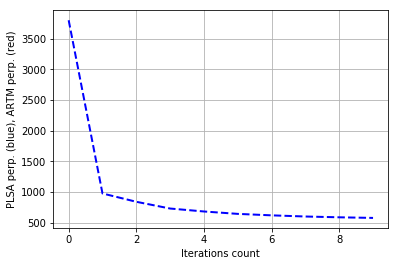

In [73]:
print_measures(model)

In [74]:
model.regularizers['sparse_phi_regularizer'].tau = -0.5
model.regularizers['sparse_theta_regularizer'].tau = -0.5

In [75]:
%time model.fit_offline(batch_vectorizer, num_collection_passes=10)

CPU times: user 7.1 s, sys: 60 ms, total: 7.16 s
Wall time: 2.68 s


Sparsity Phi: 0.881
Sparsity Theta: 0.730
Kernel contrast: 0.753
Kernel purity: 0.810
Perplexity: 572.118


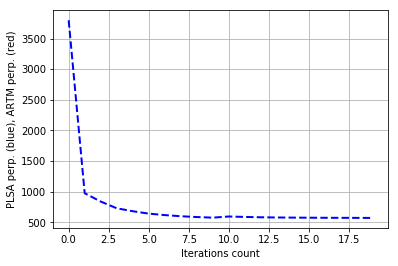

In [76]:
print_measures(model)

In [77]:
for i, topic in enumerate(model.topic_names):
    print(topic + ':', end=" ")
    for word in model.score_tracker['TopTokensScore'].last_tokens[topic]:
        print(word, end=" ")
    print()

topic_1: вообще свой планшет аппарат брать купить либо отзыв друг выбор стоить техника дорогой использовать момент 
topic_2: видеокарта дизайн устройство достаточно данный задача качество пользователь современный любой выполнять высокий замечать отлично решение 
topic_3: стоять программа бук хотеться машина обычный скорость гиг получать проц запуск должный спокойно фотошоп операционный_система 
topic_4: идти устанавливать драйвер понимать офис файл настройка последний сайт купить_ноутбук ставить вопрос установка возникать программа 
topic_5: общий месяц давать включать советовать открывать полный купить нетбук постоянно точно лично низкий подключать делать 
topic_6: работа ничто взять подходить игровой оставаться целое находить итог вариант дома добавлять смотреть_фильм ожидать учеба 
topic_7: играть греться порт нагрузка держать средний вентилятор устраивать охлаждение комп фпс разъем система_охлаждение нагреваться выдавать 
topic_8: клавиатура звук самый большой клавиша удобно рабочи

In [78]:
names_of_topics = ['topic_' + str(x) for x in range(1, num_of_topics + 1)]
array = [1, 5, 9]
topic_poss = ['topic_' + str(x) for x in range(1, num_of_topics + 1) if x not in array]

In [ ]:
3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15

In [ ]:
2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15

In [ ]:
2, 3, 4, 5, 6?, 7, 10, 12, 13, 15

## Get documents

In [79]:
theta = model.get_theta()

In [80]:
theta.shape

(15, 15623)

In [81]:
theta.head()

,12000,12001,12002,12003,12004,12005,12006,12007,12008,12009,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
topic_1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.158754,0.000000,0.000000,...,0.000000,0.0,0.25,0.388889,0.000000,0.503681,0.000000,0.173768,0.0,0.000000
topic_2,0.0,0.000000,0.225747,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,...,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.182775,0.000000,0.0,0.000000
topic_3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023062,0.287416,0.000000,...,0.000000,0.0,0.00,0.000000,0.000000,0.062500,0.000000,0.043113,0.0,0.000000
topic_4,0.0,0.000000,0.000000,0.140554,0.047501,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
topic_5,0.0,0.126952,0.000000,0.000000,0.614658,0.096305,0.538462,0.000000,0.000000,0.000000,...,0.204833,0.0,0.00,0.000000,0.333333,0.186690,0.000000,0.126890,0.0,0.324444


In [138]:
ar = [3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15] #6?, 3?

In [82]:
for i in range(15):
    j = np.argmax(theta.loc['topic_' + str(i + 1)])
    print(i + 1)
    print()
    print(pairs_text_prodid[j][0]) 
    print()

1

В-третьих, благодаря неплохо сбалансированным комплектующим, со своими обязанностями справляется на 5!

2

Катерина, данный ноутбук  превосходно подходит для работы с офисными программами, графическими приложениями и просмотра видео.

3

и обе играют.только нид фо спид(андекавер)не много притормаживает.немного совсем.иногда поглючивает.но это терпимо.играть не мешает.

4

Покупал в МВидео по безналу со скидкой в 5 %, дешевле такую конфигурацию ни где не нашел, просмотрел много предложений, поэтому ставлю твердую пять.

5

Ноутбук просто зверь за такие деньги.ставлю 5 звезд за все ( цена,качество ).только один минус,батарея под крышкой.пользуюсь два месяца,от возможностей,мощи и качества голова кругом.

6

!ХР конешно на него лучше не ставить,самы оптимальный вариант Семёрка...Берите не пожалеете,лучшее соотношение качества ипроизводительности к цене.

7

Под нагрузкой компьютер греется умеренно, колени не обжигает, вентиляторы работают негромко.

8

На мой взгляд, отличный девайс, и

In [140]:
phi = model.get_phi(model_name=model.model_pwt)

In [37]:
ser = theta.apply(lambda array: np.argmax(array), raw=True)

In [198]:
ind = np.array(ser[ser == 3].index)

In [38]:
for i in range(15):
    print(i, sum(ser == i))

0 1948
1 1253
2 896
3 1024
4 1259
5 813
6 1761
7 1062
8 1438
9 1250
10 1530
11 1720
12 1562
13 1444
14 1487


In [39]:
from pymystem3 import Mystem
m = Mystem()
def normalize_text_new(text, noun=False):
    text_normalized = []
    text = ''.join(char for char in text.lower() if char.isalpha() or char == ' ' or char == '\n')
    analysis = m.analyze(text)
    for word in analysis:
        if 'analysis' in word:
            if len(word['analysis']):
                word_norm = word['analysis'][0]['lex']
                form = word['analysis'][0]['gr'].split('=')[0].split(',')[0]
                if not noun or noun and form == 'S':
                    text_normalized.append(word_norm)
    return text_normalized

In [40]:
from stop_words import get_stop_words
stop_words = get_stop_words('russian')

In [41]:
from nltk.tokenize import sent_tokenize

In [42]:
def normalize_data(data, verbose=True):
    data = data.fillna('')
    comments = np.array(data['TEXT'])
    norm_comments = []
    for i, comment in enumerate(comments):
        norm_comments_text = []
        comment_sen = sent_tokenize(comment)
        for sen in comment_sen:
            text = normalize_text_new(sen, noun=True)
            norm_comments_text.append(' '.join([t for t in text if t not in stop_words]))
            if verbose and i % 1000 == 0:
                print(i, end=' ')
        norm_comments.append(norm_comments_text)
    return norm_comments

In [43]:
def simil(sen):
    topic_prob = []
    for topic in phi.columns:
        topic_sum = 0
        for word in sen.split():
            if word in phi.index:
                topic_sum += phi[topic].loc[word]
        if len(sen.split()):
            topic_sum /= len(sen.split())
        topic_prob.append((topic, topic_sum))
    return topic_prob

In [44]:
def sentim(sen):
    count = 0
    s_sum = 0
    for i, word in enumerate(sen):
        s = Dict.get(word, 0)
        if s != 0:
            count += 1
            if i >= 1:
                if sen[i - 1] == 'не':
                    s = - s
            s_sum += s
    if count:
        s_sum = s_sum / count
    return s_sum

In [45]:
def rang_score(sents, topic_sent):
    topic_prob = sents['topic_prob'] / sents['topic_prob'].max()
    sent = (4 - (sents['sent'] - topic_sent).abs()) / 4
    def filter_len(s):
        if s < 4:
            return 0
        if 4 <= s < 8:
            return 0.6
        if 8 <= s < 20:
            return 1
        if 20 <= s < 60:
            return (60 - s) / 40
        if s >= 60:
            return 0
    text_len = sents['text_len'].apply(filter_len)
    if (sents['like_diff'] < 0).sum() == 0:
        if sents['like_diff'].max() != 0:
            like_diff = sents['like_diff'] / sents['like_diff'].max()
        else:
            like_diff = sents['like_diff']
    else:
        if (sents['like_diff'] + abs(sents['like_diff'].min())).max() != 0:
            like_diff = (sents['like_diff'] + abs(sents['like_diff'].min())) /\
                        (sents['like_diff'] + abs(sents['like_diff'].min())).max()
        else:
            like_diff = (sents['like_diff'] + abs(sents['like_diff'].min()))
    score = 0.4 * topic_prob + 0.2 * sent + 0.3 * text_len + 0.1 * like_diff
    return sents.loc[score.argmax(), 'text']

In [83]:
filtered_not_normed_texts = pd.DataFrame(pairs_text_prodid, columns=['text', 'idx'])
filtered_not_normed_texts.head()

,text,idx
0,"Так как установили Windows 7, видеокарта Nvide...",169
1,Установленной оперативки хватает на практическ...,171
2,"С брендом производителя определились сразу, та...",176
3,Пока ноутбук отключен от сети можно успеть и ...,176
4,Белый цвет – белая клавиатура и рамка давно бы...,179


In [84]:
filtered_not_normed_texts['product'] = pd.Series([0] * filtered_not_normed_texts.shape[0])
filtered_not_normed_texts['like_diff'] = pd.Series([0] * filtered_not_normed_texts.shape[0])

In [85]:
for i in filtered_not_normed_texts.index:
    idx = int(filtered_not_normed_texts.loc[i, 'idx'])
    filtered_not_normed_texts.loc[i, 'product'] = df1.loc[idx, 'PRODUCT']
    filtered_not_normed_texts.loc[i, 'like_diff'] = df1.loc[idx, 'LIKES_COUNT'] - df1.loc[idx, 'DISLIKES_COUNT']
filtered_not_normed_texts['like_diff'] = filtered_not_normed_texts['like_diff'].\
                        fillna(filtered_not_normed_texts['like_diff'].mean())

In [86]:
filtered_not_normed_texts.head()

,text,idx,product,like_diff
0,"Так как установили Windows 7, видеокарта Nvide...",169,30024761,1.0
1,Установленной оперативки хватает на практическ...,171,30024762,2.0
2,"С брендом производителя определились сразу, та...",176,30024764,8.0
3,Пока ноутбук отключен от сети можно успеть и ...,176,30024764,8.0
4,Белый цвет – белая клавиатура и рамка давно бы...,179,30024765,4.0


In [102]:
res = []
for k, product in enumerate(filtered_not_normed_texts.groupby('product')):
    if k == 2:
        cur_res = []
        sents = pd.DataFrame([], columns=['text', 'topic', 'topic_prob', 'sent', 'text_len', 'like_diff'])
        topic_sent = {}
        for i, idx in enumerate(product[1].index):
            topic_probs = theta[idx][theta.index.isin(topic_poss)]
            print(topic_probs)
            topic_best = topic_probs.argmax()
            if topic_probs.loc[topic_best] > 0.01:
                norm_text = normalize_text_new(product[1].loc[idx, 'text'])
                sent = sentim(norm_text)
                prev_sent = topic_sent.get((topic_best, product[1].loc[idx, 'idx']), (0, 0))
                topic_sent[(topic_best, product[1].loc[idx, 'idx'])] = (prev_sent[0] + sent, prev_sent[1] + 1)

                like_diff = product[1].loc[idx, 'like_diff']
                sents = sents.append({'text': product[1].loc[idx, 'text'], 'topic': topic_best,
                                      'topic_prob': topic_probs.loc[topic_best], 'sent': sent,
                                      'text_len': len(product[1].loc[idx, 'text'].split()),
                                      'like_diff': like_diff}, ignore_index=True)
        for topic in topic_sent:
            topic_sent[topic] = topic_sent[topic][0] / topic_sent[topic][1]
        res_topic_sent = {}
        for topic in topic_sent:
            prev_sent = res_topic_sent.get(topic[0], (0, 0))
            res_topic_sent[topic[0]] = (prev_sent[0] + topic_sent[topic], prev_sent[1] + 1)
        for topic in res_topic_sent:
            res_topic_sent[topic] = res_topic_sent[topic][0] / res_topic_sent[topic][1]
        for topic in res_topic_sent:
            sentence = rang_score(sents[sents['topic'] == topic], res_topic_sent[topic])
            cur_res.append([topic, res_topic_sent[topic], sentence])
        if k % 1000 == 0:
            print(k, end=' ')
        print(res_topic_sent)
        print(sents)
        res.append(cur_res)

topic_2     0.000000
topic_3     0.230769
topic_4     0.076923
topic_6     0.000000
topic_7     0.000000
topic_8     0.000000
topic_10    0.000000
topic_11    0.000000
topic_12    0.000000
topic_13    0.076923
topic_14    0.538462
topic_15    0.000000
Name: 12709, dtype: float32
topic_2     0.0
topic_3     0.2
topic_4     0.0
topic_6     0.0
topic_7     0.0
topic_8     0.2
topic_10    0.0
topic_11    0.2
topic_12    0.0
topic_13    0.0
topic_14    0.2
topic_15    0.0
Name: 12710, dtype: float32
topic_2     0.00000
topic_3     0.00000
topic_4     0.00000
topic_6     0.00000
topic_7     0.00000
topic_8     0.00000
topic_10    0.00000
topic_11    0.00000
topic_12    0.00000
topic_13    0.00000
topic_14    0.67079
topic_15    0.00000
Name: 12711, dtype: float32
{'topic_14': -0.13174603174603175, 'topic_3': 0.80000000000000004}
                                                text     topic  topic_prob  \
0  Приобрели в 2008 году и до сих пор работает))\...  topic_14    0.538462   
1  Проц х

In [95]:
res

[[['topic_4',
   -0.41666666666666663,
   'А кстати АКБ держит у меня макс 3 часа активной работы, если снимать все побочные приложения.'],
  ['topic_6',
   0.0,
   'Был случай, что ноут работал 2 с хвостиком месяца не выключаясь (сервер) и ничего.']]]

In [89]:
for i, topic in enumerate(model.topic_names):
    print(topic + ':', end=" ")
    for word in model.score_tracker['TopTokensScore'].last_tokens[topic]:
        print(word, end=" ")
    print()

topic_1: вообще свой планшет аппарат брать купить либо отзыв друг выбор стоить техника дорогой использовать момент 
topic_2: видеокарта дизайн устройство достаточно данный задача качество пользователь современный любой выполнять высокий замечать отлично решение 
topic_3: стоять программа бук хотеться машина обычный скорость гиг получать проц запуск должный спокойно фотошоп операционный_система 
topic_4: идти устанавливать драйвер понимать офис файл настройка последний сайт купить_ноутбук ставить вопрос установка возникать программа 
topic_5: общий месяц давать включать советовать открывать полный купить нетбук постоянно точно лично низкий подключать делать 
topic_6: работа ничто взять подходить игровой оставаться целое находить итог вариант дома добавлять смотреть_фильм ожидать учеба 
topic_7: играть греться порт нагрузка держать средний вентилятор устраивать охлаждение комп фпс разъем система_охлаждение нагреваться выдавать 
topic_8: клавиатура звук самый большой клавиша удобно рабочи